In [21]:
import os
import json
import time
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
from typing import List

import umap
import umap.plot

import torch
from torch.utils.data import DataLoader
from torch import optim
from sklearn.model_selection import train_test_split

from utils.transformer import SimpleTransformerRec
from utils.preprocess import FeatureLabelEncoder, SequenceGenerator, SequentialDataset

# Load Dataset

In [22]:
DOMAIN = "fashion"

current_dir = os.path.abspath(os.curdir)
base_dir = "/".join(current_dir.split("/")[:-1])
dataset_dir = Path(base_dir).joinpath(f"data/dataset/{DOMAIN}/interactions")
model_dir = Path(base_dir).joinpath(f"data/model/{DOMAIN}/transformer")
model_dir.mkdir(parents=True, exist_ok=True)

In [23]:
df = pd.read_parquet(dataset_dir)
df.head()
df["date"] = pd.to_datetime(df["timestamp"].apply(lambda x: x[:10]), format="%Y-%m-%d")

# User Behavior Sequence

In [24]:
df_agg = df.groupby(["date", "user_id"])["item_id"].agg(n_items="nunique").reset_index()
df_agg = df_agg.groupby("date")["n_items"].mean().reset_index()
df_agg = df_agg[df_agg["date"] < "2025-10-01"].reset_index(drop=True)

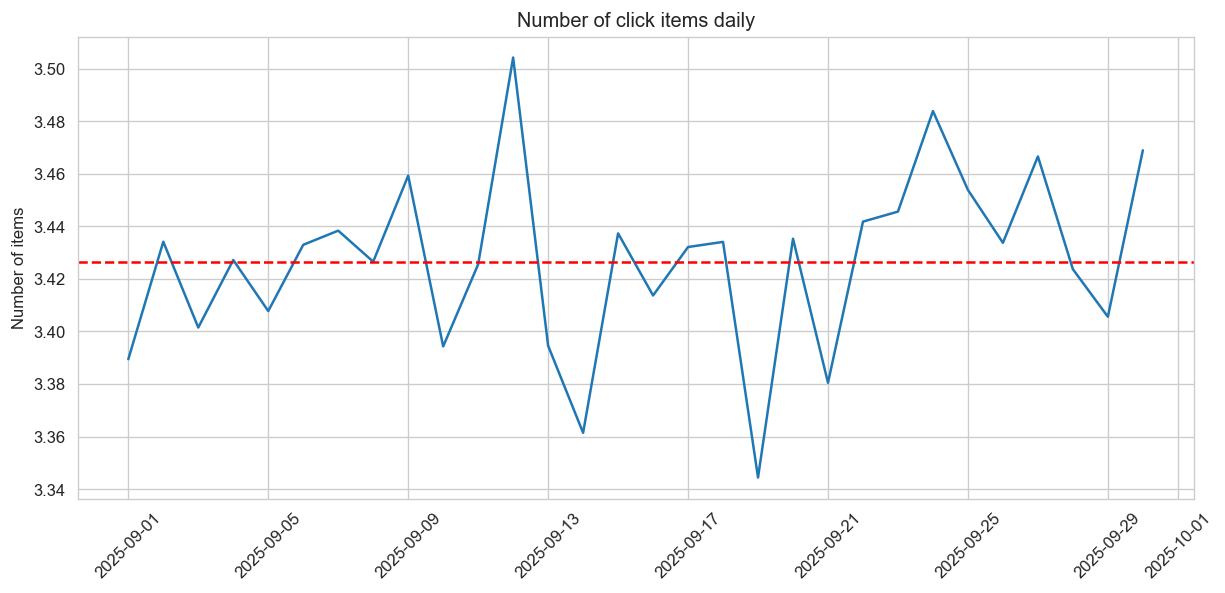

In [25]:
plt.figure(figsize=(12, 5), dpi=120)
sns.lineplot(data=df_agg, x="date", y="n_items")
plt.xlabel("")
plt.ylabel("Number of items")
plt.xticks(rotation=45)
plt.axhline(y=df_agg["n_items"].mean(), color="r", linestyle="--")
plt.title("Number of click items daily")
plt.show()

In [26]:
max_seq_len = 4

# Preprocess

## Label Encoding

In [27]:
feature_names = ["color", "style", "fit", "material", "season", "sleeve", "category"]

label_encoders = FeatureLabelEncoder()
df_tmp = pd.concat(
    [
        pd.DataFrame([dict(zip(feature_names, ["NONE"] * len(feature_names)))]),
        pd.DataFrame([dict(zip(feature_names, ["-1"] * len(feature_names)))]),
    ]
)
df_prep = pd.concat([df[feature_names], df_tmp])
label_encoders.fit(df_prep)
df_encoded = label_encoders.transform(df_prep)

for column in ["item_id", "user_id", "timestamp"]:
    values = df[column].to_list()
    random_values = values[: df_tmp.shape[0]]
    df_encoded[column] = values + random_values
print(df_encoded.shape)
df_encoded[["user_id", "item_id", "timestamp"] + feature_names].head()

# Mask로 처리할 인덱스가 모두 0으로 인코딩 되었는지 확인
for x in feature_names:
    x_encoded = label_encoders._all_encoders[x].transform(["-1"])
    x_decoded = label_encoders._all_encoders[x].inverse_transform([0])
    print(f"{x}: {x_encoded} -> {x_decoded}")

(161348, 10)
color: [0] -> ['-1']
style: [0] -> ['-1']
fit: [0] -> ['-1']
material: [0] -> ['-1']
season: [0] -> ['-1']
sleeve: [0] -> ['-1']
category: [0] -> ['-1']


In [28]:
model_dir.joinpath(f"label_encoders/").mkdir(parents=True, exist_ok=True)

for feature, encoder in label_encoders.all_encoders.items():
    file_name = f"{feature}.joblib"
    file_path = model_dir.joinpath(f"label_encoders/{file_name}")
    joblib.dump(encoder, file_path)

## Sequence Generation

In [9]:
target_names = feature_names

sequence_generator = SequenceGenerator(max_seq_len=max_seq_len)
df_seq_encoded = sequence_generator.get_seq_dataframe(
    data=df_encoded,
    feature_sequences=feature_names,
    output_targets=target_names,
)

# `item_id` 타겟 추가
df_seq_encoded["y_item_id"] = df_seq_encoded.groupby("user_id")["item_id"].shift(-1)

# Null target 제거
df_seq_encoded = df_seq_encoded[df_seq_encoded["y_item_id"].notnull()]

print(df_seq_encoded.shape)

(151348, 20)


In [10]:
df_seq_encoded.head()

,user_id,item_id,user_rn,seq_len,mask,color,style,fit,material,season,sleeve,category,y_color,y_style,y_fit,y_material,y_season,y_sleeve,y_category,y_item_id
0,1,6099,1,4,"[0, 0, 0, 0]","[17, 17, 6, 6]","[7, 7, 9, 9]","[3, 2, 4, 6]","[9, 3, 7, 6]","[2, 6, 5, 6]","[1, 5, 7, 7]","[17, 17, 8, 8]",17,2,6,12,2,5,17,8096.0
1,1,8096,2,4,"[0, 0, 0, 0]","[6, 17, 17, 17]","[9, 2, 2, 2]","[6, 6, 6, 7]","[6, 12, 14, 10]","[6, 2, 6, 6]","[7, 5, 7, 1]","[8, 17, 17, 17]",16,2,2,14,6,7,3,4411.0
2,1,4411,3,4,"[0, 0, 0, 0]","[17, 6, 6, 17]","[7, 9, 9, 2]","[2, 4, 6, 6]","[3, 7, 6, 12]","[6, 5, 6, 2]","[5, 7, 7, 5]","[17, 8, 8, 17]",17,2,6,14,6,7,17,3730.0
3,1,3730,4,4,"[0, 0, 0, 0]","[6, 6, 17, 17]","[9, 9, 2, 2]","[4, 6, 6, 6]","[7, 6, 12, 14]","[5, 6, 2, 6]","[7, 7, 5, 7]","[8, 8, 17, 17]",17,2,7,10,6,1,17,1679.0
4,1,1679,5,4,"[0, 0, 0, 0]","[17, 16, 16, 11]","[2, 2, 2, 9]","[7, 2, 2, 4]","[10, 14, 10, 11]","[6, 6, 3, 6]","[1, 7, 1, 1]","[17, 3, 3, 3]",1,1,1,1,1,2,1,5383.0


# Model

## Model Config

In [11]:
def set_model_config(
    df: pd.DataFrame, feature_names: List[str], target_names: List[str], seq_len: int
) -> dict:
    feature_dims = {}
    for feature in feature_names:
        feature_dims[feature] = np.max(df[feature].to_list()).item() + 1

    embedding_dim = 64
    output_dims = {}
    for target in target_names:
        output_dims[target] = df[target].nunique()

    return dict(
        seq_len=seq_len,
        feature_dims=feature_dims,
        embedding_dim=embedding_dim,
        output_dims=output_dims,
        global_pool="sum",
    )


print("------------------ Model Config ------------------")
config = set_model_config(
    df=df_encoded,
    feature_names=feature_names,
    target_names=feature_names,
    seq_len=max_seq_len,
)
print(config)

checkpoint = model_dir.joinpath("checkpoint")
checkpoint.mkdir(parents=True, exist_ok=True)

with open(checkpoint.joinpath("model_config.json"), "w") as f:
    json.dump(config, f, ensure_ascii=False, indent=4)

------------------ Model Config ------------------
{'seq_len': 4, 'feature_dims': {'color': 18, 'style': 13, 'fit': 8, 'material': 16, 'season': 7, 'sleeve': 8, 'category': 23}, 'embedding_dim': 64, 'output_dims': {'color': 18, 'style': 13, 'fit': 8, 'material': 16, 'season': 7, 'sleeve': 8, 'category': 23}, 'global_pool': 'sum'}


## Dataset

In [12]:
df_train, df_test = train_test_split(
    df_seq_encoded, test_size=0.2, random_state=42, shuffle=True
)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
train_dataset = SequentialDataset(
    df=df_train, feature_sequences=feature_names + ["mask"], targets=target_names
)

batch_size = 128
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False
)

## Training

In [14]:
device = "cpu"

torch.autograd.set_detect_anomaly(True)

# Model
model = SimpleTransformerRec(**config)

# Loss functions
loss_funcs = {
    target: torch.nn.CrossEntropyLoss(ignore_index=0).to(device)
    for target in target_names
}

# Optimizers
optimizer = optim.AdamW(model.parameters(), weight_decay=0.01, lr=0.001)

df_metrics = pd.DataFrame()
n_epochs = 10
model = model.to(device)
for epoch in range(n_epochs):
    train_start_time = time.time()
    model.train()

    running_loss = {target: 0 for target in target_names}
    accuracy = {}
    for target in target_names:
        accuracy.update({target: {"token": [], "sequence": []}})

    for _, (feature_sequences, masks, targets) in enumerate(
        tqdm(train_dataloader, total=len(train_dataloader))
    ):
        optimizer.zero_grad()
        outputs = model(feature_sequences=feature_sequences, masks=masks)[1]
        losses = {target: 0 for target in target_names}
        for target, dim in config["output_dims"].items():
            batch_size = targets[target].size()[0]

            # logits_flat: (seq_len * batch_size, n_classes)
            logits_flat = outputs[target].permute(1, 0, 2).reshape(-1, dim)

            # targets_flat: (batch_size * seq_len)
            targets_flat = targets[target].reshape(-1).long()

            losses[target] = loss_funcs[target](logits_flat, targets_flat)

            # pred_flat: (batch_size * seq_len)
            pred_flat = logits_flat.argmax(dim=-1)

            # Token-Level Accuracy (예측 시퀀스와 Target 시퀀스 내 동일한 원소 비율)
            correct = (pred_flat == targets_flat) & (targets_flat != 0)
            valid_token_cnt = (targets_flat != 0).sum().item()
            # division by zero 에러 방지
            if valid_token_cnt > 0:
                token_accuracy = correct.sum().item() / valid_token_cnt
            else:
                token_accuracy = 0.0

            # Sequence-Level Accuracy (예측 시퀀스와 Target 시퀀스가 동일한 비율)
            # pred: (seq_len, batch_size)
            pred = pred_flat.reshape(batch_size, model.seq_len)
            sequence_correct = ((pred == targets[target]) & (masks.long() == 0)).all(
                dim=1
            )
            sequence_accuracy = sequence_correct.sum().item() / batch_size

            accuracy[target]["token"].append(token_accuracy)
            accuracy[target]["sequence"].append(sequence_accuracy)

        total_loss = sum(losses.values())
        total_loss.backward()
        optimizer.step()

        for target, loss in losses.items():
            running_loss[target] += loss.item()
        running_loss["total"] = total_loss.item()

    torch.save(model.state_dict(), checkpoint.joinpath("model.pt"))

    train_end_time = time.time()
    train_time = round(train_end_time - train_start_time, 2)
    print(f"Epoch {epoch + 1}/{n_epochs} - Loss & Accuracy (Token, Sequence)")
    for target in target_names:
        loss = running_loss[target] / len(train_dataloader)
        token_accuracy = np.mean(accuracy[target]["token"])
        sequence_accuracy = np.mean(accuracy[target]["sequence"])
        print(
            f"Loss `{target}`: {loss:.4f} ({token_accuracy:.2%}, {sequence_accuracy:.2%})"
        )

        df_metrics_tmp = pd.DataFrame(
            {
                "epoch": [epoch + 1],
                "target": [target],
                "loss": [loss],
                "token_accuracy": [token_accuracy],
                "sequence_accuracy": [sequence_accuracy],
            }
        )
        df_metrics = pd.concat([df_metrics, df_metrics_tmp], ignore_index=True)
    print(f"Total Loss: {running_loss['total']:.4f}")
    print(f"Elapsed time(sec): {train_time:.2f}\n")

df_metrics.to_csv(model_dir.joinpath("metrics_train.csv"), index=False)

/Users/hwangyungwan/miniforge3/envs/ds_p313/lib/python3.13/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  0%|          | 0/946 [00:00<?, ?it/s]

Epoch 1/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.2496 (96.94%, 76.41%)
Loss `style`: 0.1991 (97.69%, 77.37%)
Loss `fit`: 0.1269 (98.82%, 79.15%)
Loss `material`: 0.2415 (96.74%, 75.88%)
Loss `season`: 0.1075 (99.36%, 80.11%)
Loss `sleeve`: 0.1273 (98.83%, 79.02%)
Loss `category`: 0.3129 (95.49%, 74.73%)
Total Loss: 0.0634
Elapsed time(sec): 88.69



  0%|          | 0/946 [00:00<?, ?it/s]

Epoch 2/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0059 (100.00%, 81.46%)
Loss `style`: 0.0049 (100.00%, 81.46%)
Loss `fit`: 0.0033 (100.00%, 81.46%)
Loss `material`: 0.0053 (100.00%, 81.46%)
Loss `season`: 0.0029 (100.00%, 81.46%)
Loss `sleeve`: 0.0032 (100.00%, 81.46%)
Loss `category`: 0.0067 (100.00%, 81.46%)
Total Loss: 0.0166
Elapsed time(sec): 89.61



  0%|          | 0/946 [00:00<?, ?it/s]

Epoch 3/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0019 (100.00%, 81.46%)
Loss `style`: 0.0016 (100.00%, 81.46%)
Loss `fit`: 0.0011 (100.00%, 81.46%)
Loss `material`: 0.0017 (100.00%, 81.46%)
Loss `season`: 0.0010 (100.00%, 81.46%)
Loss `sleeve`: 0.0011 (100.00%, 81.46%)
Loss `category`: 0.0022 (100.00%, 81.46%)
Total Loss: 0.0060
Elapsed time(sec): 89.64



  0%|          | 0/946 [00:00<?, ?it/s]

Epoch 4/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0009 (100.00%, 81.46%)
Loss `style`: 0.0007 (100.00%, 81.46%)
Loss `fit`: 0.0005 (100.00%, 81.46%)
Loss `material`: 0.0008 (100.00%, 81.46%)
Loss `season`: 0.0004 (100.00%, 81.46%)
Loss `sleeve`: 0.0005 (100.00%, 81.46%)
Loss `category`: 0.0010 (100.00%, 81.46%)
Total Loss: 0.0035
Elapsed time(sec): 89.70



  0%|          | 0/946 [00:00<?, ?it/s]

Epoch 5/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0005 (100.00%, 81.46%)
Loss `style`: 0.0004 (100.00%, 81.46%)
Loss `fit`: 0.0003 (100.00%, 81.46%)
Loss `material`: 0.0004 (100.00%, 81.46%)
Loss `season`: 0.0002 (100.00%, 81.46%)
Loss `sleeve`: 0.0003 (100.00%, 81.46%)
Loss `category`: 0.0005 (100.00%, 81.46%)
Total Loss: 0.0019
Elapsed time(sec): 89.45



  0%|          | 0/946 [00:00<?, ?it/s]

Epoch 6/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0008 (99.99%, 81.45%)
Loss `style`: 0.0005 (100.00%, 81.46%)
Loss `fit`: 0.0004 (100.00%, 81.46%)
Loss `material`: 0.0007 (100.00%, 81.45%)
Loss `season`: 0.0003 (100.00%, 81.46%)
Loss `sleeve`: 0.0003 (100.00%, 81.46%)
Loss `category`: 0.0008 (100.00%, 81.45%)
Total Loss: 0.0012
Elapsed time(sec): 89.43



  0%|          | 0/946 [00:00<?, ?it/s]

Epoch 7/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0001 (100.00%, 81.46%)
Loss `style`: 0.0001 (100.00%, 81.46%)
Loss `fit`: 0.0001 (100.00%, 81.46%)
Loss `material`: 0.0001 (100.00%, 81.46%)
Loss `season`: 0.0001 (100.00%, 81.46%)
Loss `sleeve`: 0.0001 (100.00%, 81.46%)
Loss `category`: 0.0002 (100.00%, 81.46%)
Total Loss: 0.0005
Elapsed time(sec): 89.22



  0%|          | 0/946 [00:00<?, ?it/s]

Epoch 8/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0005 (100.00%, 81.45%)
Loss `style`: 0.0004 (100.00%, 81.46%)
Loss `fit`: 0.0003 (100.00%, 81.46%)
Loss `material`: 0.0007 (99.99%, 81.42%)
Loss `season`: 0.0002 (100.00%, 81.46%)
Loss `sleeve`: 0.0004 (99.99%, 81.43%)
Loss `category`: 0.0006 (99.99%, 81.45%)
Total Loss: 0.0008
Elapsed time(sec): 89.40



  0%|          | 0/946 [00:00<?, ?it/s]

Epoch 9/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0001 (100.00%, 81.46%)
Loss `style`: 0.0001 (100.00%, 81.46%)
Loss `fit`: 0.0000 (100.00%, 81.46%)
Loss `material`: 0.0001 (100.00%, 81.46%)
Loss `season`: 0.0000 (100.00%, 81.46%)
Loss `sleeve`: 0.0000 (100.00%, 81.46%)
Loss `category`: 0.0001 (100.00%, 81.46%)
Total Loss: 0.0002
Elapsed time(sec): 90.08



  0%|          | 0/946 [00:00<?, ?it/s]

Epoch 10/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0003 (100.00%, 81.46%)
Loss `style`: 0.0002 (100.00%, 81.46%)
Loss `fit`: 0.0003 (99.99%, 81.44%)
Loss `material`: 0.0003 (100.00%, 81.45%)
Loss `season`: 0.0002 (100.00%, 81.46%)
Loss `sleeve`: 0.0005 (99.99%, 81.42%)
Loss `category`: 0.0003 (100.00%, 81.46%)
Total Loss: 0.0002
Elapsed time(sec): 89.32



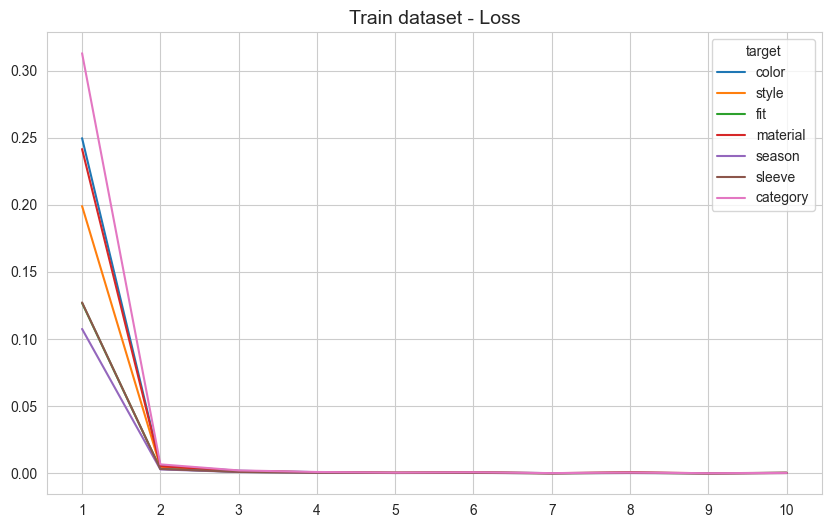

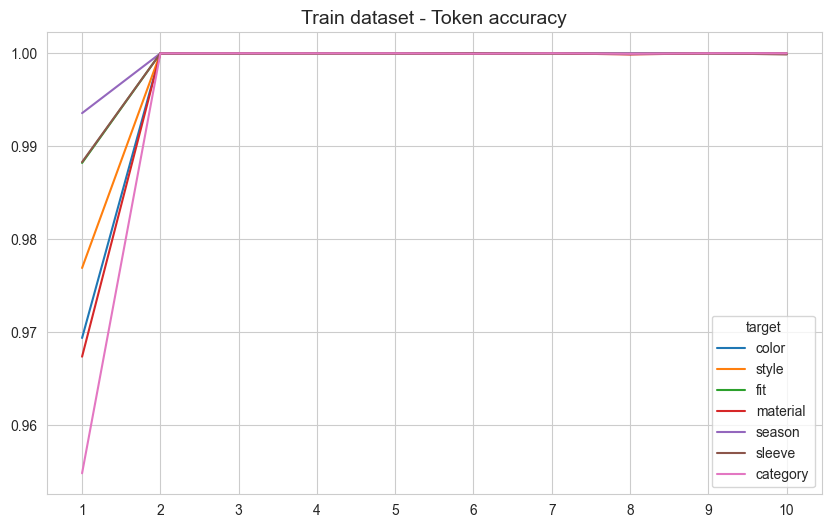

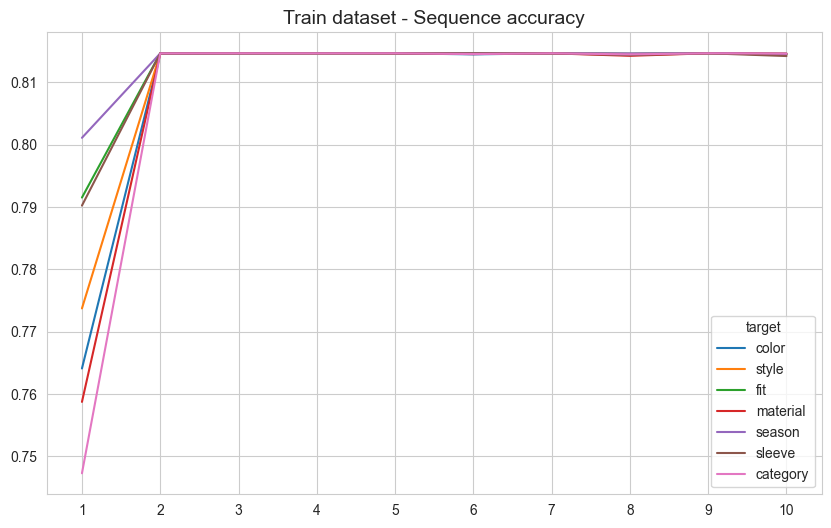

In [15]:
df_metrics = pd.read_csv(model_dir.joinpath("metrics_train.csv"))

for metric in ["loss", "token_accuracy", "sequence_accuracy"]:
    plt.figure(figsize=(10, 6), dpi=100)
    sns.lineplot(x="epoch", y=metric, hue="target", data=df_metrics)
    plt.title(f"Train dataset - {metric.replace('_', ' ').capitalize()}", fontsize=14)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(np.arange(1, df_metrics["epoch"].max() + 1, 1))
    plt.show()

## Evaluation

In [16]:
test_dataset = SequentialDataset(
    df=df_test, feature_sequences=feature_names + ["mask"], targets=target_names
)

batch_size = 128
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval().to(device)
with torch.no_grad():
    accuracy = {}
    for target in target_names:
        accuracy.update({target: {"token": [], "sequence": []}})

    for _, (feature_sequences, masks, targets) in enumerate(
        tqdm(test_dataloader, total=len(test_dataloader))
    ):
        outputs = model(feature_sequences=feature_sequences, masks=masks)[1]

        for target, dim in config["output_dims"].items():
            batch_size = targets[target].size()[0]

            # logits_flat: (batch_size * seq_len, n_classes)
            logits_flat = outputs[target].permute(1, 0, 2).reshape(-1, dim)

            # targets_flat: (batch_size * seq_len)
            targets_flat = targets[target].reshape(-1).long()

            # pred_flat: (batch_size * seq_len)
            pred_flat = logits_flat.argmax(dim=-1)

            # Token-Level Accuracy (예측 시퀀스와 Target 시퀀스 내 동일한 원소 비율)
            correct = (pred_flat == targets_flat) & (targets_flat != 0)
            valid_token_cnt = (targets_flat != 0).sum().item()
            # division by zero 에러 방지
            if valid_token_cnt > 0:
                token_accuracy = correct.sum().item() / valid_token_cnt
            else:
                token_accuracy = 0.0

            # Sequence-Level Accuracy (예측 시퀀스와 Target 시퀀스가 동일한 비율)
            # pred: (seq_len, batch_size)
            pred = pred_flat.reshape(batch_size, model.seq_len)
            sequence_correct = ((pred == targets[target]) & (masks.long() == 0)).all(
                dim=1
            )
            sequence_accuracy = sequence_correct.sum().item() / batch_size

            accuracy[target]["token"].append(token_accuracy)
            accuracy[target]["sequence"].append(sequence_accuracy)

    df_metrics = pd.DataFrame()
    print("Accuracy (Token, Sequence)")
    for i, target in enumerate(target_names):
        token_accuracy = np.mean(accuracy[target]["token"])
        sequence_accuracy = np.mean(accuracy[target]["sequence"])
        print(f"`{target}`: {token_accuracy:.2%}, {sequence_accuracy:.2%}")

        df_metrics_tmp = pd.DataFrame(
            {
                "target": [target],
                "token_accuracy": [token_accuracy],
                "sequence_accuracy": [sequence_accuracy],
            }
        )
        df_metrics = pd.concat([df_metrics, df_metrics_tmp], ignore_index=True)

df_metrics.to_csv(model_dir.joinpath("metrics_test.csv"), index=False)

  0%|          | 0/237 [00:00<?, ?it/s]

Accuracy (Token, Sequence)
`color`: 100.00%, 81.61%
`style`: 100.00%, 81.61%
`fit`: 100.00%, 81.61%
`material`: 100.00%, 81.61%
`season`: 100.00%, 81.61%
`sleeve`: 100.00%, 81.61%
`category`: 100.00%, 81.61%


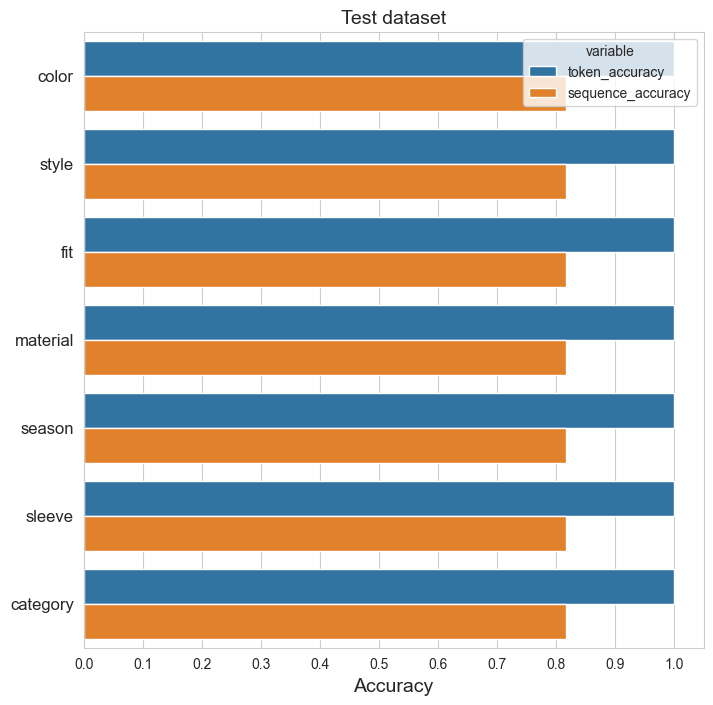

In [17]:
df_metrics = pd.read_csv(model_dir.joinpath("metrics_test.csv"))
df_metrics = df_metrics.melt(id_vars="target")
plt.figure(figsize=(8, 8), dpi=100)
sns.barplot(data=df_metrics, x="value", y="target", hue="variable")
plt.title("Test dataset", fontsize=14)
plt.xlabel("Accuracy", fontsize=14)
plt.ylabel("", fontsize=14)
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(fontsize=12)
plt.show()

# Feature Vectors

In [18]:
df_tmp = df_seq_encoded[feature_names + ["mask", "y_item_id"]]

dataset = SequentialDataset(
    df=df_tmp, feature_sequences=feature_names + ["mask"], device=device
)

dataloader = DataLoader(dataset, batch_size=512, shuffle=False, pin_memory=False)

user_vectors = []
with torch.no_grad():
    for _, (feature_sequences, masks) in enumerate(
        tqdm(dataloader, total=len(dataloader))
    ):
        outputs = model(feature_sequences=feature_sequences, masks=masks)[0]

        outputs = outputs.detach().numpy()
        user_vectors.extend([value / np.linalg.norm(value) for value in outputs])

df_user_vectors = df_seq_encoded[feature_names + ["y_item_id"]].copy()
df_user_vectors["user_vectors"] = user_vectors
user_vectors = np.array(df_user_vectors["user_vectors"].tolist())

  0%|          | 0/296 [00:00<?, ?it/s]

In [19]:
user_vectors.shape

(151348, 64)

/var/folders/9r/nl1h4s_n0wx65wzr5cmq1hy80000gn/T/ipykernel_3379/3652985023.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


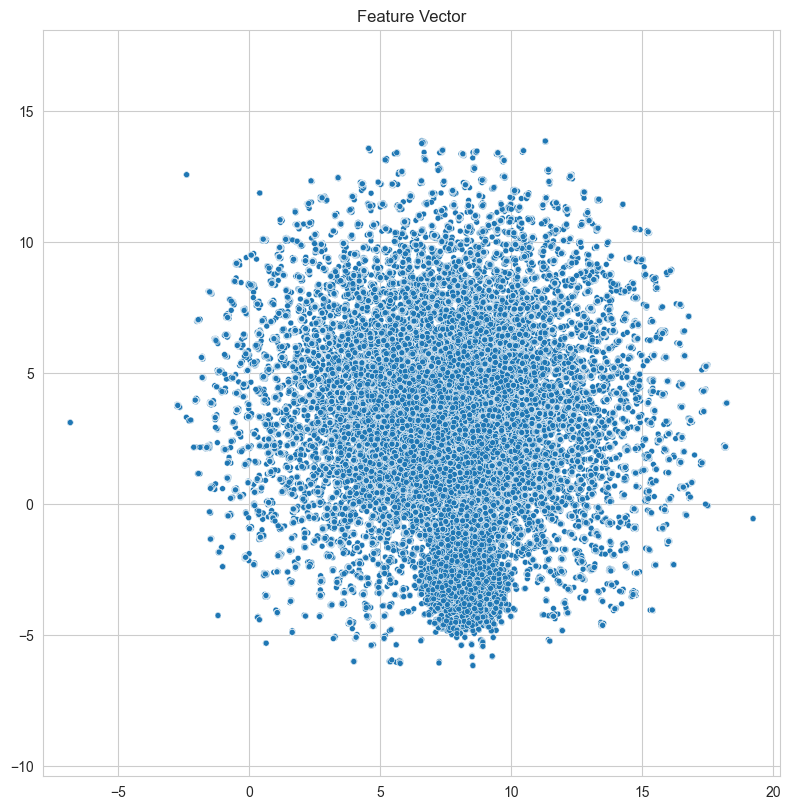

In [20]:
reducer = umap.UMAP(metric="cosine", n_neighbors=15)
embeddings = reducer.fit_transform(user_vectors)

plt.figure(figsize=(8, 8))
sns.scatterplot(
    x=embeddings[:, 0], y=embeddings[:, 1], size=0.3, palette="bright", legend=False
)
plt.gca().set_aspect("equal", "datalim")
plt.tight_layout()
plt.title("Feature Vector")
plt.show()